<a href="https://colab.research.google.com/github/HarshaGowtham/Toxicity_classification_NLP/blob/master/Toxicity_classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [29]:
train_df = pd.read_csv('/content/drive/MyDrive/work_space/My_projects/Toxicity_classification_NLP/train.csv', index_col = 'id')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [30]:
test_df = pd.read_csv('/content/drive/MyDrive/work_space/My_projects/Toxicity_classification_NLP/test.csv', index_col = 'id')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [31]:
train_df.shape

(1804874, 44)

## **EXPLORATORY DATA ANALYSIS**

Checking the missing values :

In [32]:
train_df.isna().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

In [33]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


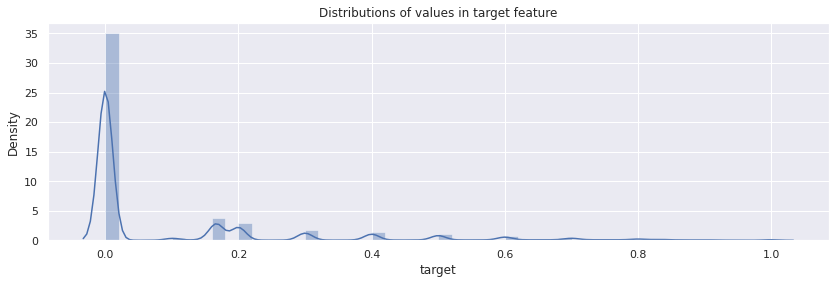

In [35]:
plt.figure(figsize= (14, 4))
plt.title("Distributions of values in target feature")
sns.set_theme(color_codes= True)
feature = train_df['target']
sns.distplot(train_df['target'] , label = feature )
plt.show()


## **Detecting the outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


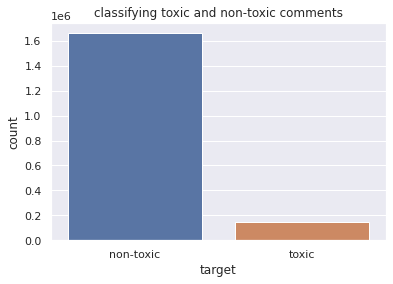

In [36]:
t_cat = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")
temp=[]
plt.title('classifying toxic and non-toxic comments')
sns.countplot(t_cat)
plt.show()




**Here we have large number of non toxic comments compared to toxic comments and the data set is imbalanced**

**Now we have the nature of the toxicity**


*   severe_toxicity
*   obscene
*   insult
*   threat
*   identity_attack






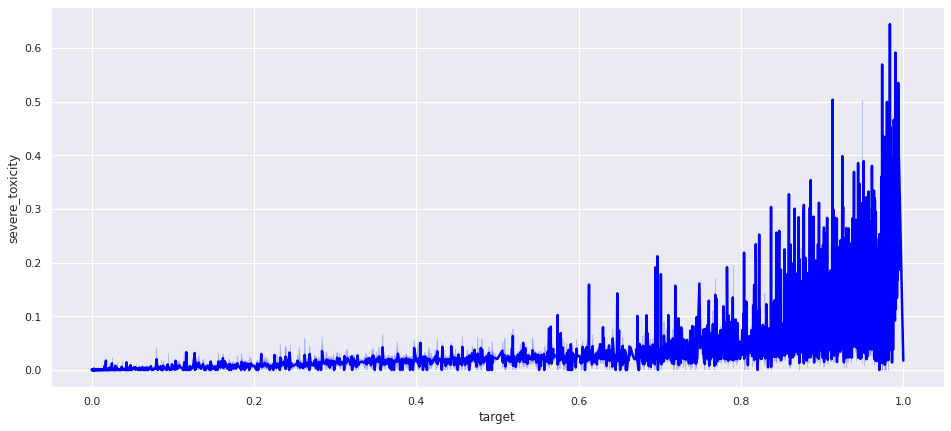

In [37]:
plt.figure(figsize= (16,7))
sns.set_style()
ax = sns.lineplot(x= train_df['target'], y=train_df["severe_toxicity"] , color = 'blue' , linewidth = 2.5)
plt.show()

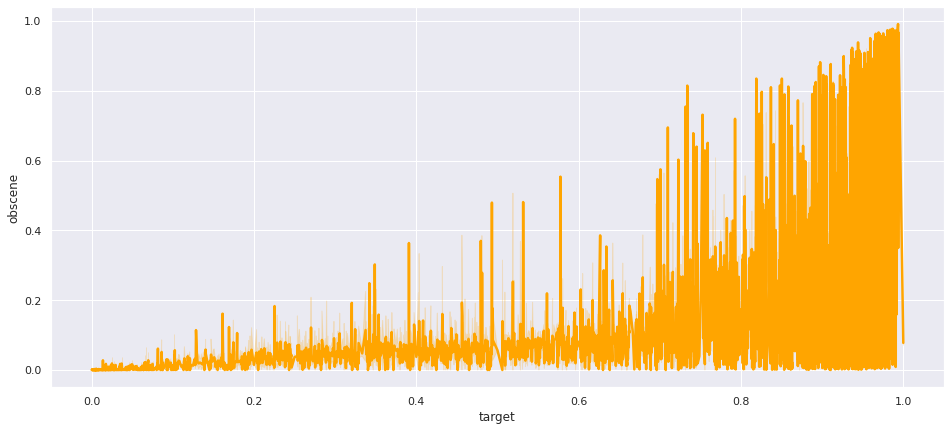

In [38]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["obscene"] , color = 'orange' , linewidth = 2.5)
plt.show()

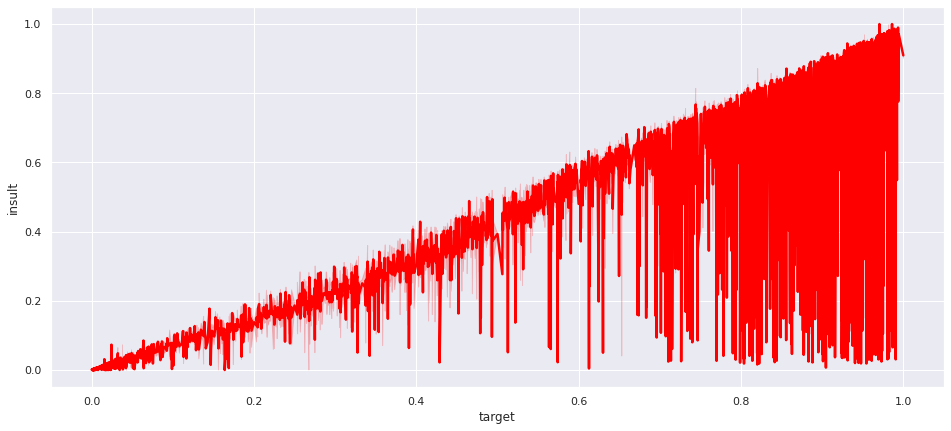

In [39]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["insult"] , color = 'red' , linewidth = 2.5)
plt.show()

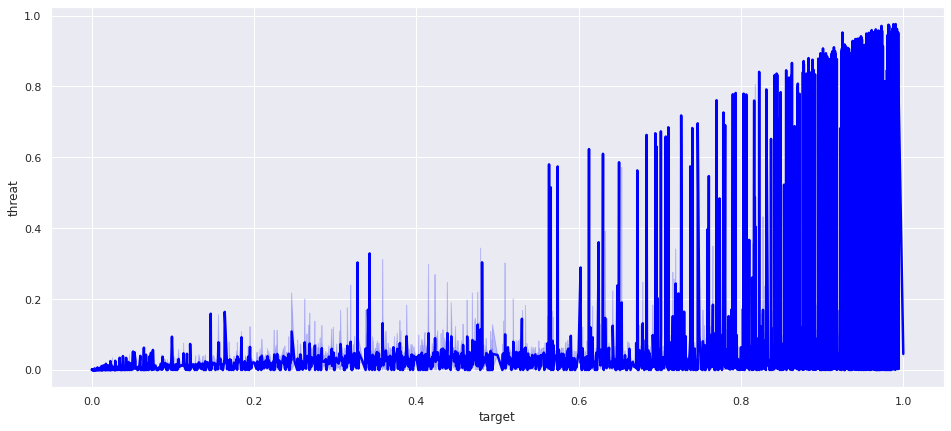

In [40]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["threat"] , color = 'blue' , linewidth = 2.5)
plt.show()

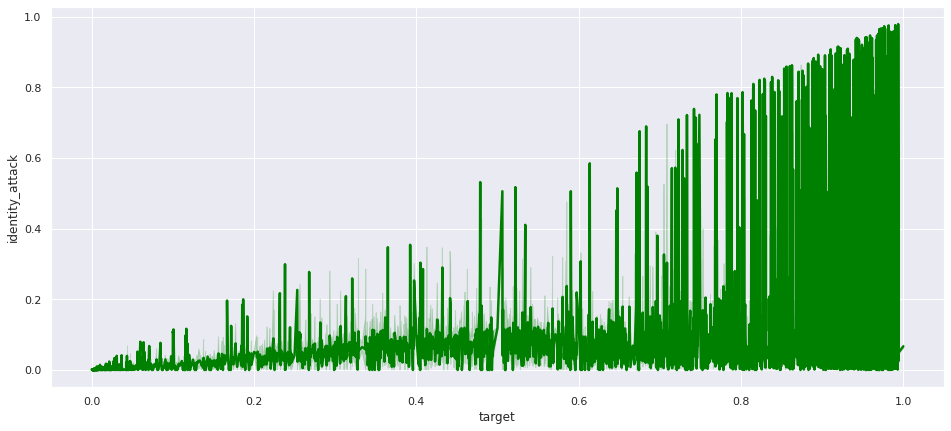

In [41]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["identity_attack"] , color = 'green' , linewidth = 2.5)
plt.show()

In [42]:
def toxic_nature_distributions(dataframe, features, title):
  plt.figure(figsize=(12,6))
  plt.title(title)
  for feature in features:
    sns.distplot( dataframe[feature], kde = True, hist = False, bins = 240, label = feature )
  plt.xlabel('')
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

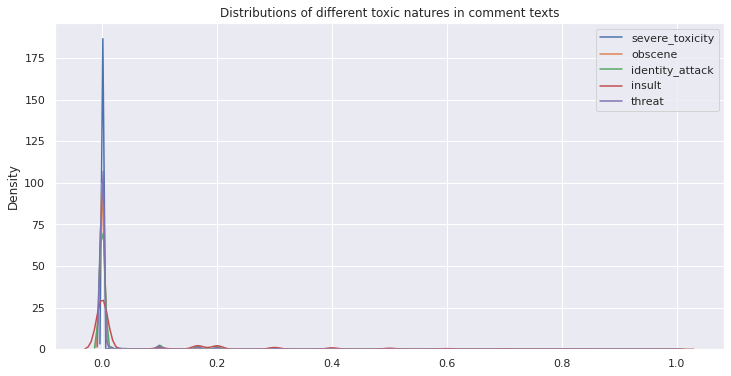

In [43]:
##distributions of toxic nature columns

features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
toxic_nature_distributions(train_df , features, 'Distributions of different toxic natures in comment texts')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

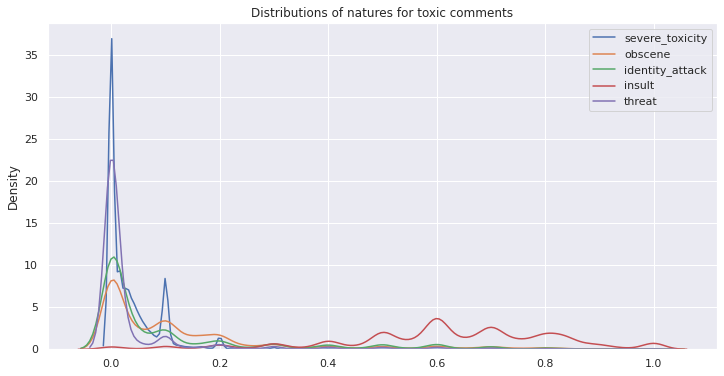

In [44]:
## distributions of toxic nature columns which are considered toxic (target > 0.5)
toxic_comments = train_df[train_df['target'] > 0.5]
toxic_nature_distributions(toxic_comments , features, 'Distributions of natures for toxic comments')

**Here we see that most of the toxic comments have insult in nature. We can also say that there are more insulting comments**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

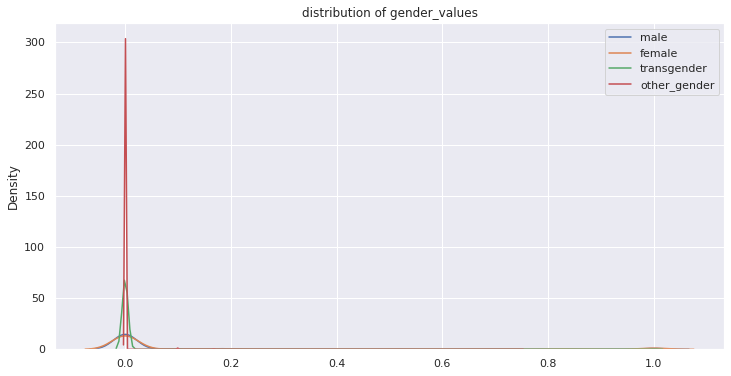

In [45]:
#looking at the identity attributes
#distribution of gender_values
toxic_comments = train_df.dropna(axis = 0, how = 'any')
features = ['male', 'female', 'transgender', 'other_gender']
toxic_nature_distributions(toxic_comments , features , 'distribution of gender_values')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

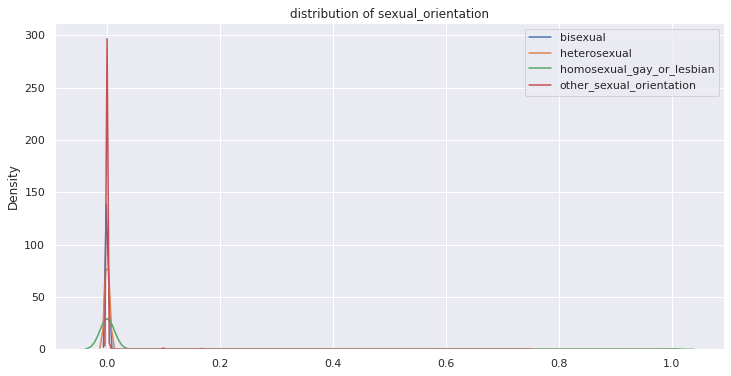

In [46]:
#distribution of sexual_orientation
toxic_comments = train_df.dropna(axis = 0, how = 'any')
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
toxic_nature_distributions(toxic_comments , features , 'distribution of sexual_orientation')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

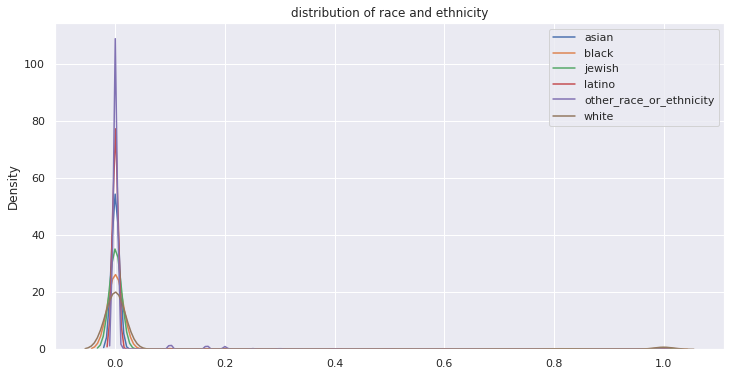

In [47]:
##distribution of race and ethnicity
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
toxic_nature_distributions(toxic_comments , features , 'distribution of race and ethnicity')




In [48]:
def user_feedback(feature, title, dataframe, size=1):
  f, ax = plt.subplots(1,1, figsize=(4*size,4))
  cntplot= sns.countplot(dataframe[feature], order = dataframe[feature].value_counts().index[:20], palette='Set3')
  cntplot.set_title('distribution of {}'.format(title))
  plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


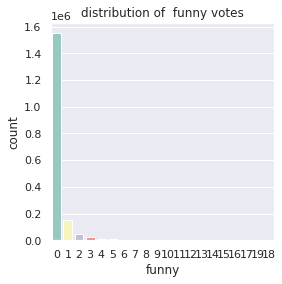

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


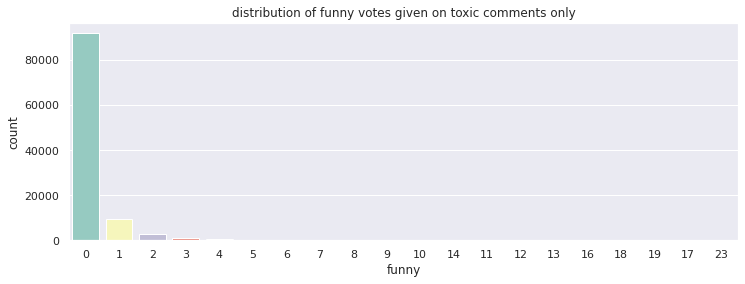

In [49]:
user_feedback('funny' , ' funny votes' , train_df) 
user_feedback('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


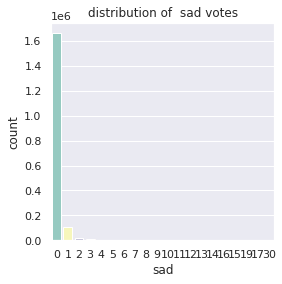

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


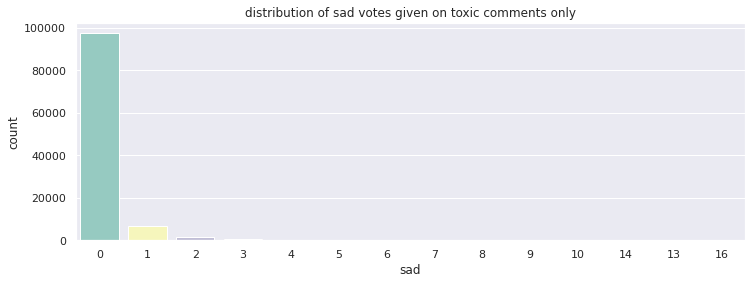

In [50]:
user_feedback('sad' , ' sad votes' , train_df) 
user_feedback('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


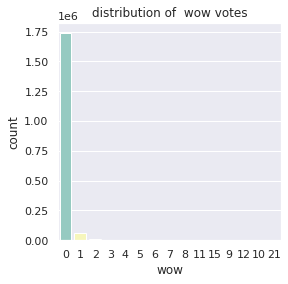

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


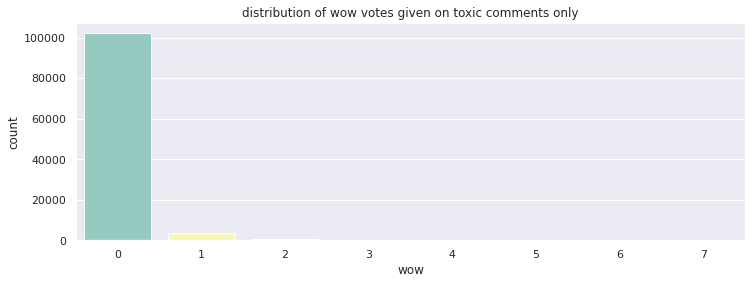

In [51]:
user_feedback('wow' , ' wow votes' , train_df) 
user_feedback('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


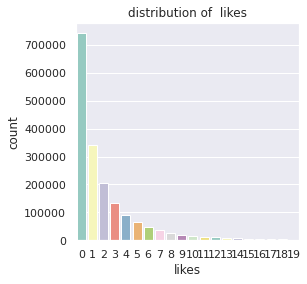

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


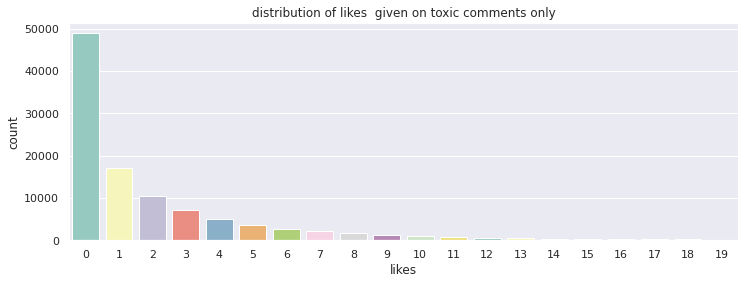

In [52]:
user_feedback('likes' , ' likes' , train_df) 
user_feedback('likes', 'likes  given on toxic comments only', train_df[train_df['target'] > 0.5], 3)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


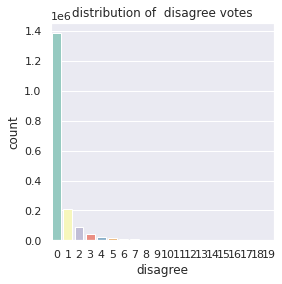

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


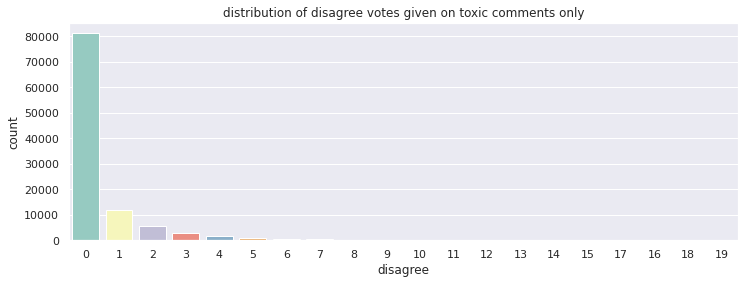

In [53]:
user_feedback('disagree' , ' disagree votes' , train_df) 
user_feedback('disagree', 'disagree votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)



**COMMENTS TEXT**

In [57]:
def show_wordcloud(dataframe, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(dataframe))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

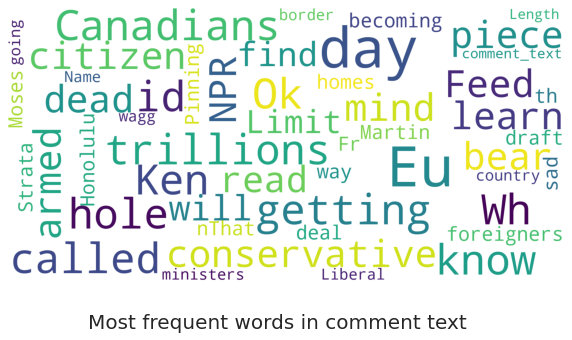

In [61]:
show_wordcloud(train_df['comment_text'].sample(20000) , title = 'Most frequent words in comment text')

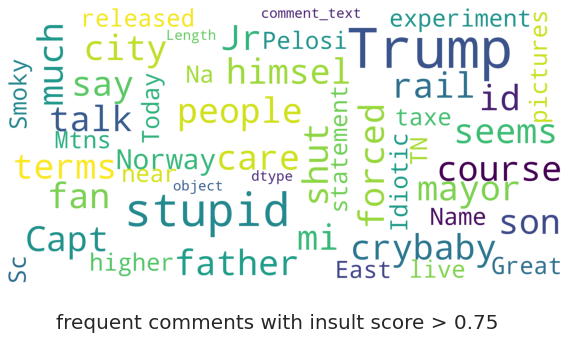

In [65]:
show_wordcloud(train_df[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'frequent comments with insult score > 0.75')

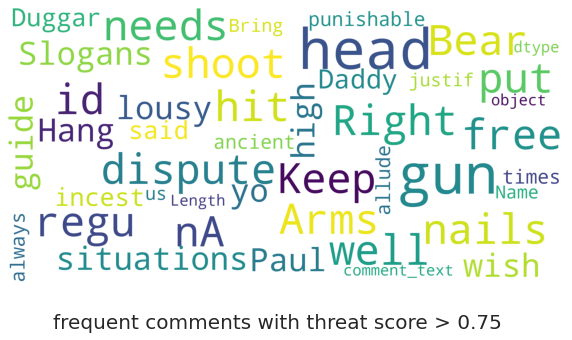

In [70]:
show_wordcloud(train_df[train_df['threat'] > 0.75]['comment_text'], 
               title = 'frequent comments with threat score > 0.75')

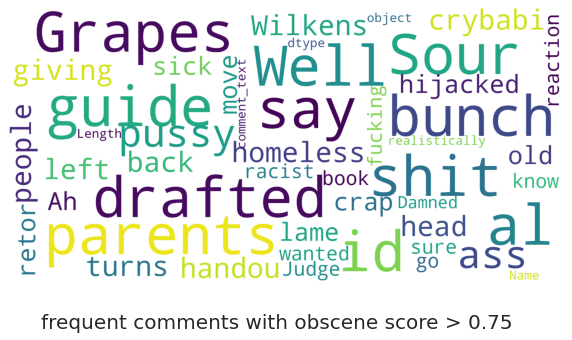

In [71]:
show_wordcloud(train_df[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'frequent comments with obscene score > 0.75')

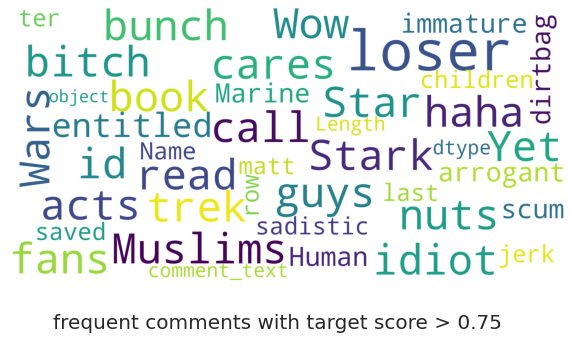

In [72]:
show_wordcloud(train_df[train_df['target'] > 0.75]['comment_text'], 
               title = 'frequent comments with target score > 0.75')

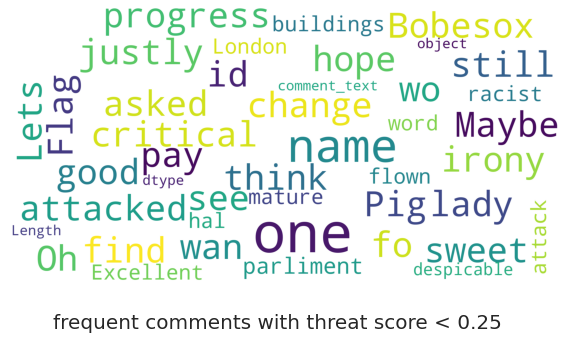

In [73]:
show_wordcloud(train_df[train_df['threat'] < 0.25]['comment_text'].sample(20000), 
               title = 'frequent comments with threat score < 0.25')

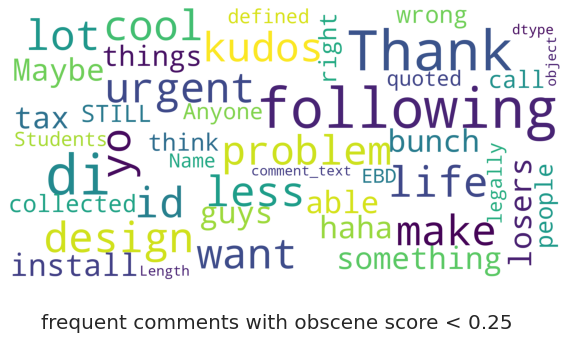

In [74]:
show_wordcloud(train_df[train_df['obscene'] < 0.25]['comment_text'], 
               title = 'frequent comments with obscene score < 0.25')

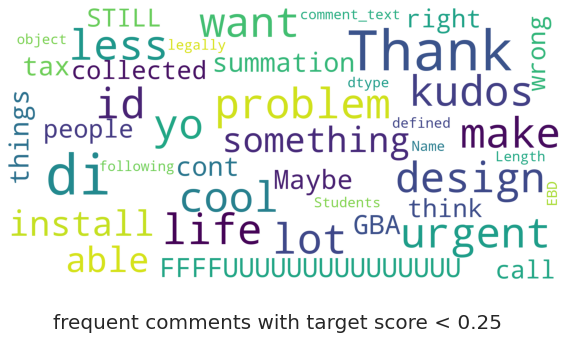

In [75]:
show_wordcloud(train_df[train_df['target'] < 0.25]['comment_text'], 
               title = 'frequent comments with target score < 0.25')

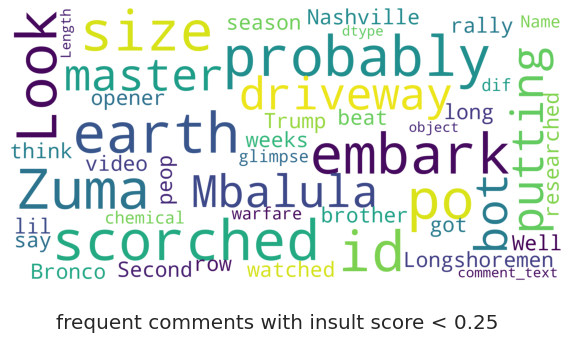

In [76]:
show_wordcloud(train_df[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'frequent comments with insult score < 0.25')